# Agente Simples com Roteamento

## Visão Gerão


* Nosso modelo de chat decidirá fazer ou não uma chamada de ferramenta com base na entrada do usuário
* Usamos uma aresta condicional para rotear para um nó que chamará nossa ferramenta ou simplesmente terminará

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Objetivos

Agora, podemos estender isso para uma arquitetura de agente genérica.

No roteador acima, invocamos o modelo e, se ele escolheu chamar uma ferramenta, retornamos uma `ToolMessage` para o usuário.
 
Mas, e se simplesmente passarmos essa `ToolMessage` *de volta para o modelo*?

Podemos deixá-lo (1) chamar outra ferramenta ou (2) responder diretamente.

Esta é a intuição por trás do [ReAct](https://react-lm.github.io/), uma arquitetura de agente geral.
  
* `act` - deixe o modelo chamar ferramentas específicas 
* `observe` - passe a saída da ferramenta de volta para o modelo 
* `reason` - deixe o modelo raciocinar sobre a saída da ferramenta para decidir o que fazer a seguir (por exemplo, chamar outra ferramenta ou apenas responder diretamente)

Esta [arquitetura de propósito geral](https://blog.langchain.dev/planning-for-agents/) pode ser aplicada a muitos tipos de ferramentas. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [14]:

%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [7]:
# Configuração de variáveis de ambiente
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Vamos usar o conhecido Langsmith para [tracing](https://docs.smith.langchain.com/concepts/tracing).
# 
Agora vamos logar no LangSmith, `scoras-academy`. 

In [8]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "scoras-academy"

In [9]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiplica a e b.

    Args:
        a: primeiro int
        b: segundo int
    """
    return a * b


# Essa função será uma ferramenta
def add(a: int, b: int) -> int:
    """Soma a e b.

    Args:
        a: primeiro int
        b: segundo int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a por b.

    Args:
        a: primeiro int
        b: segundo int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

Vamos criar nosso LLM e pedir para ele se comportar como um agente.


In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


   # Mensagem de sistema
sys_msg = SystemMessage(content="Você é um assistente solicito e gentil que faz contas.")

# Nó
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Como antes, usamos `MessagesState` e definimos um nó `Tools` com nossa lista de ferramentas.

O nó `Assistant` é apenas nosso modelo com as ferramentas vinculadas.

Criamos um grafo com os nós `Assistant` e `Tools`.

Adicionamos a aresta `tools_condition`, que direciona para `End` ou para `Tools` com base em se o `Assistant` chama uma ferramenta ou não.

Agora, adicionamos uma nova etapa:

Conectamos o nó `Tools` *de volta* ao `Assistant`, formando um loop.

* Após a execução do nó `assistant`, `tools_condition` verifica se a saída do modelo é uma chamada de ferramenta.
* Se for uma chamada de ferramenta, o fluxo é direcionado para o nó `tools`.
* O nó `tools` se conecta de volta ao `assistant`.
* Este loop continua enquanto o modelo decidir chamar ferramentas.
* Se a resposta do modelo não for uma chamada de ferramenta, o fluxo é direcionado para END, terminando o processo.

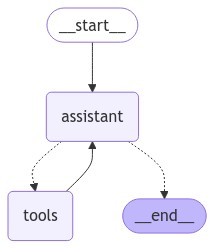

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


# Todos os nós precisam estar definidos antes de criar o grafo
tools = [add, multiply, divide]  

# Criando o grafo
builder = StateGraph(MessagesState)

# Adicionando nós
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Adicionando arestas: essas determinam como o fluxo de controle se move
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # Se a última mensagem (resultado) do assistente é uma chamada de ferramenta -> tools_condition roteia para ferramentas
    # Se a última mensagem (resultado) do assistente não é uma chamada de ferramenta -> tools_condition roteia para END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Mostrando o grafo
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages = [HumanMessage(content="Soma 3 e 4, depois multiplica por 2, e finalmente divide por 5")]
messages = react_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Soma 3 e 4, depois multiplica por 2, e finalmente divide por 5
================================== Ai Message ==================================
Tool Calls:
  add (call_sPVog4J2N2oOImrIuqC5ZfG2)
 Call ID: call_sPVog4J2N2oOImrIuqC5ZfG2
  Args:
    a: 3
    b: 4
  multiply (call_MFVQDgnYGjfG6g5oZuEM8I04)
 Call ID: call_MFVQDgnYGjfG6g5oZuEM8I04
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_q8lOXNsW5EHgcXU8GFJSS39T)
 Call ID: call_q8lOXNsW5EHgcXU8GFJSS39T
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ========

## LangSmith

Podemos olhar os traces no LangSmith.